## Use ip_isr Task to make brighter-fatter kernel from a set of high-intensity flats.
Michael Wood-Vasey  (2018-08-21)

Jim Chiang kindly created a set of Phosim and ImSim flats at NERSC:

* ImSim flat pairs are `/global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_*r.fits`
ImSim visits are 161899, 161900
* PhoSim flat pairs are `/global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a*.fits`.  
There are three pairs in u at 70k, 80k, and 90k e-/pixel, and three pairs in i for the same signal levels.   Note that these are in the *ImSim* `raw` format since the original PhoSim runs didn't generate the amplifier files, so I can't (easily) make PhoSim `raw`s.  

The visit numbers for these PhoSim flat pairs are 0..11.

Use `lsst.obs.lsstCam.ImsimMapper` for both on ingest.

Jim also made a set of flat pairs for R22_S11 for a sequence of signal levels, from 10k to 80k e-/pixel, in steps of 10k.  One might use these to look at the full photon transfer curve ("non-linearity").  
`/global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/ptc_dataset/lsst_a*.fits` 

The pairs can be identified by looking for the shorter `EXPTIME` values.

### Logistics

* Versions  
This was run through the JupyterLab environment at NERSC (https://jupyter-dev.nersc.gov) based on `w_2018_26`
but with a custom kernelspec that loaded a set of local checkouts of

```
obs_base tickets/DM-13293
obs_lsstCam tickets/DM-15509
cp_pipe tickets/DM-13293
```

file:/global/homes/w/wmwv/.local/share/jupyter/kernels/desc-stack-obs-lsstCam
file:/global/homes/w/wmwv/.local/share/jupyter/kernels/desc-stack-obs-lsstCam/kernel.json
file:/global/homes/w/wmwv/.local/share/jupyter/kernels/desc-stack-obs-lsstCam/desc-stack-obs-lsstCam.sh

* Hacks
  - Because I was basing this off of `w_2018_26`, I additionally had to
    * comment-out the `exposure.setWcs` command in the raw assembly in `obs_lsstCam`.
    * Define a warpper `run` method in `makeBrighterFatterTask.py` that calls `runDataRef`.
  - The `cp_pipe` tickets/DM-13293 is still under review and currently has a dependency on `eotest` in the default set of things that get loaded when loading the `cp_pipe` module.  I manually commented out
  ```
  #     from .cpTask import *
  ```
  in the `cp_pipe/python/lsst/cp/pipe/__init__.py` file.

## References
* See Andrew Bradshaw's [StackClub](https://github.com/LSSTScienceCollaborations/StackClub) notebook studying the brighter-fatter effect on stars and galaxies projected from the lab-based beam simulator.
  - [Rendered] http://nbviewer.jupyter.org/url/andrewnomy.com/sync/BrighterFatterCorrection.ipynb?flush_cache=true
  - [Raw] https://github.com/LSSTScienceCollaborations/StackClub/blob/project/beamsim/andrewkbradshaw/ImageProcessing/BrighterFatterCorrection.ipynb


In [ ]:
# pre-store the calculation of the gains
! mkdir calib_repo/calibration

In [3]:
# Test to make sure that we can import obs_lsstCam
import lsst.obs.base
import lsst.obs.lsstCam

In [4]:
from lsst.daf.persistence import Butler

In [4]:
# Do biases first since constructDark.py expects them.
from lsst.pipe.tasks.ingest import IngestTask

arg_string = 'calib_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/bias_files/*.fits --mode link'
args = ' '.split(arg_string)

# But this doesn't actually work because IngestImages only uses sys.argv.
# It doesn't accept an args passthrough to the `parseAndRun` method.
# IngestTask.parseAndRun(args=args)

In [5]:
# So we call out to the shell with a !
### we don't even need bias or dark just to test out generation of the BF kernel.
# ! ingestImages.py calib_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/bias_files/*.fits --mode link
# ! ingestImages.py calib_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/dark_files/*.fits --mode link
! ingestImages.py calib_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a*.fits --mode link

root INFO: Loading config overrride file '/global/homes/w/wmwv/local/lsst/obs_lsstCam/config/ingest.py'
LsstCamMapper WARN: Unable to find calib root directory
CameraMapper INFO: Loading Posix exposure registry from /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo
ingest INFO: /global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a_000000_R22_S11.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo/raw/0/R22/00000000-R22-S11-det094-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a_000001_R22_S11.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo/raw/1/R22/00000001-R22-S11-det094-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a_000002_R22_S11.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo/raw/2/R22/00000002-R22-S11-det094-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/d

In [10]:
# This is clearly wrong.
nominalGain = \
{'C00': 1.0,
 'C01': 1.0,
 'C02': 1.0,
 'C03': 1.0,
 'C04': 1.0,
 'C05': 1.0,
 'C06': 1.0,
 'C07': 1.0,
 'C10': 1.0,
 'C11': 1.0,
 'C12': 1.0,
 'C13': 1.0,
 'C14': 1.0,
 'C15': 1.0,
 'C16': 1.0,
 'C17': 1.0}

In [5]:
butler = Butler('calib_repo')

In [12]:
gain = nominalGain
dataRef = butler.dataRef('brighterFatterGain', dataId={'detector':94}) 
dataRef.put(gain, 'brighterFatterGain')   

In [1]:
from lsst.cp.pipe.makeBrighterFatterKernel import MakeBrighterFatterKernelTask

args = ['calib_repo', '--rerun', 'test',
        '--id', 'detector=94',
        '--visit-pairs', '1,5', '3,9', '4,8', '10,2', '0,11', '6,7',
        '-c',
        'xcorrCheckRejectLevel=2', 'doCalcGains=False',
        '--clobber-config', '--clobber-versions'
       ]

mandatory = ['doAssembleCcd']
forbidden_all = ['doApplyGains', 'normalizeGains', 'doFlat', 'doFringe', 'doAddDistortionModel',
             'doBrighterFatter', 'doUseOpticsTransmission', 'doUseFilterTransmission',
             'doUseSensorTransmission', 'doUseAtmosphereTransmission', 'doGuider', 'doStrayLight',
             'doTweakFlat']
forbidden = ['doFlat', 'doFringe', 'doAddDistortionModel',
             'doBrighterFatter', 'doUseOpticsTransmission', 'doUseFilterTransmission',
             'doUseSensorTransmission', 'doUseAtmosphereTransmission',
             ]

# for field in mandatory:
#     args.extend(['-c', 'isr.{}=True'.format(field)])
# for field in forbidden:
#     args.extend(['-c', 'isr.{}=False'.format(field)])

command_line = 'makeBrighterFatterKernel.py ' + ' '.join(args)

print(command_line)
MakeBrighterFatterKernelTask.parseAndRun(args=args)

makeBrighterFatterKernel.py calib_repo --rerun test --id detector=94 --visit-pairs 1,5 3,9 4,8 10,2 0,11 6,7 -c xcorrCheckRejectLevel=2 doCalcGains=False --clobber-config --clobber-versions


Struct(argumentParser=ArgumentParser(prog='__main__.py', usage='%(prog)s input [options]', description=None, formatter_class=<class 'argparse.RawDescriptionHelpFormatter'>, conflict_handler='error', add_help=True); parsedCmd=Namespace(butler=Butler(datasetTypeAliasDict={}, repos=RepoDataContainer(_inputs=[RepoData(id=47533893181848,repoArgs=RepositoryArgs(root='/global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo/rerun/test', cfgRoot=None, mapper=None, mapperArgs=None, tags=set(), mode='rw', policy=None)cfg=RepositoryCfg(root='/global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo/rerun/test', mapper=<class 'lsst.obs.lsstCam.lsstCamMapper.LsstCamMapper'>, mapperArgs={}, parents=[RepositoryCfg(root='/global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo', mapper=<class 'lsst.obs.lsstCam.lsstCamMapper.LsstCamMapper'>, mapperArgs={}, parents=[], policy=None)], policy=None),cfgOrigin=existing,cfgRoot=/global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/cali

It worked.  let's load in the kernel and look at it!

In [8]:
test_butler = Butler('calib_repo/rerun/test')
bf_kernel = test_butler.get('brighterFatterKernelNew', dataId={'raftName': 'R22', 'detectorName': 'S11', 'detector': 94})

In [12]:
print(bf_kernel)

{94: array([[ -4.22755701e-08,  -8.45511401e-08,  -1.26613119e-07,
         -1.67820732e-07,  -2.06912507e-07,  -2.41893057e-07,
         -2.70111031e-07,  -2.88661880e-07,  -2.95161937e-07,
         -2.88661880e-07,  -2.70111031e-07,  -2.41893057e-07,
         -2.06912507e-07,  -1.67820732e-07,  -1.26613119e-07,
         -8.45511401e-08,  -4.22755701e-08],
       [ -8.45511401e-08,  -1.69315872e-07,  -2.54080603e-07,
         -3.37757303e-07,  -4.17936240e-07,  -4.90548690e-07,
         -5.49889188e-07,  -5.89374550e-07,  -6.03323987e-07,
         -5.89374550e-07,  -5.49889188e-07,  -4.90548690e-07,
         -4.17936240e-07,  -3.37757303e-07,  -2.54080603e-07,
         -1.69315872e-07,  -8.45511401e-08],
       [ -1.26613119e-07,  -2.54080603e-07,  -3.82636119e-07,
         -5.11191636e-07,  -6.36526459e-07,  -7.52476275e-07,
         -8.49522480e-07,  -9.15623147e-07,  -9.39384911e-07,
         -9.15623147e-07,  -8.49522480e-07,  -7.52476275e-07,
         -6.36526459e-07,  -5.1119163

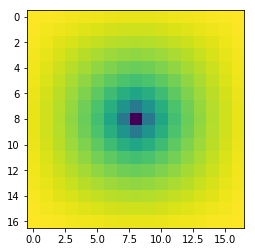

In [13]:
import matplotlib.pyplot as plt
plt.imshow(bf_kernel[94])

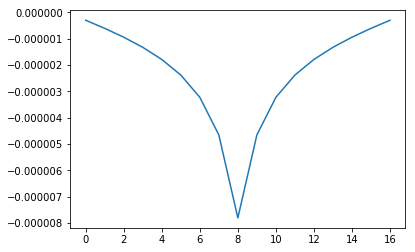

In [14]:
plt.plot(bf_kernel[94][:,8])

------

In [ ]:
from lsst.pipe.drivers.constructCalibs import BiasTask
args_line = 'calib_repo --rerun wmwv/calib --longlog --id visit=9999 --batch-type none --cores 4'
args = args_line.split(' ')
print(args)

### We're not actually going ton construct master bias or darks yet.
# BiasTask.parseAndSubmit(args=args)

In [ ]:
# ! constructBias.py calib_repo --rerun wmwv/calib --longlog --id visit=9999 --batch-type none --cores 4

root INFO: Loading config overrride file '/global/homes/w/wmwv/local/lsst/obs_lsstCam/config/bias.py'
LsstCamMapper WARN: Unable to find calib root directory
CameraMapper INFO: Loading exposure registry from /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo/registry.sqlite3
LsstCamMapper WARN: Unable to find calib root directory
root INFO: Loading config overrride file '/global/homes/w/wmwv/local/lsst/obs_lsstCam/config/bias.py'
LsstCamMapper WARN: Unable to find calib root directory
CameraMapper INFO: Loading exposure registry from /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/calib_repo/registry.sqlite3
LsstCamMapper WARN: Unable to find calib root directory
INFO  2018-08-22T11:13:07.007 root ()(cmdLineTask.py:572)- Running: /global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/pipe_drivers/16.0+4/bin/constructBias.py calib_repo --rerun wmwv/calib --longlog --id visit=9999
WARN  2018-08-22T11:13:09.009 Ls

In [ ]:

## We don't have any master calibration images yet.
# ingestCalibs.py calib_repo --output calib_repo/CALIB --validity 13000 calib_repo/rerun/wmwv/calib/bias/2022-01-01/*.fits

# Darks next, before flats.
! ingestImages.py calib_repo dark_files/*.fits --mode link

# Make a master dark
! constructDark.py calib_repo --rerun wmwv/calib_dark --longlog --id visit=4000000 --batch-type none --cores 4

# Take the master dark we just created and load it into the CALIB_ROOT.
! ingestCalibs.py calib_repo --output calib_repo/CALIB --validity 13000 calib_repo/rerun/wmwv/calib_dark/dark/1994-07-19/*.fits

# Make a master flat.
! constructFlat.py calib_repo --rerun wmwv/calib_flat --longlog --id visit=219976 raft=R34 ccd=S02 --batch-type none

In [ ]:
imsim_raw_glob = '/global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_*r.fits'
phosim_raw_glob = '/global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a*.fits'

mapper_str = 'lsst.obs.lsstCam.ImsimMapper'

Ingest the calibration files.